In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [2]:
with open("data/linear-regression-data.pkl", "rb") as f:
    data = pickle.load(f)
data.keys()

dict_keys(['length', 'force'])

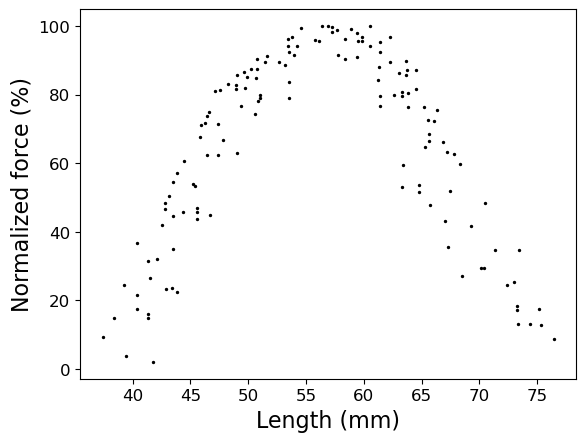

In [3]:
plt.scatter(data["length"], data["force"], c="k", s=2)
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.show()

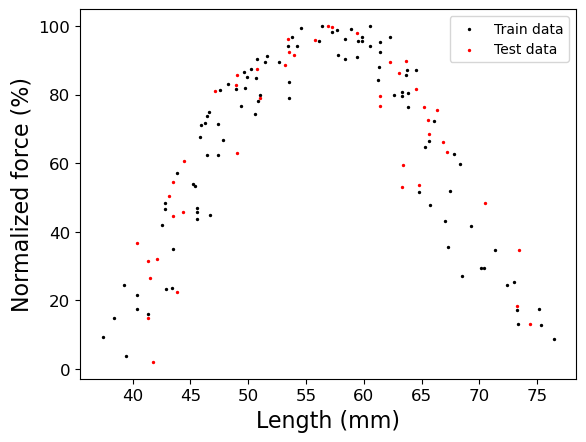

In [4]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(data["length"], data["force"], random_state=seed, test_size=45)
plt.scatter(x_train, y_train, s=2, c="k", label="Train data")
plt.scatter(x_test, y_test, s=2, c="r", label="Test data")
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.legend()
plt.show()

# Section 1: Gaussian features

TODO:
- Complete the formula for the Gaussian kernel
- Select appropriate mu and sigma for basis functions for this dataset. Use 10 basis functions
- Train the model with sklearn Ridge regression and plot predictions
    - Use alpha=1e-2 for all models
- Report on the train and test error

The formula for the Gaussian function, given parameters $\mu$ and $\sigma$, is:

$$\phi(x | \mu, \sigma) = e^{-\frac{1}{2}(\frac{x - \mu}{\sigma})^2}$$

In [6]:
# Basis functions
class Gaussian:
    def __init__(self, mu, sigma):
        """
        Class to represent the a Gaussian kernel for kernel ridge regression

        :param mu: mean of the Gaussian
        :param sigma: standard deviation of the Gaussian
        """
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        """
        :param x: array of input values for the kernel function
        :return: values of the kernel function evaluated at x
        """
        # TODO: Fill in the equation for the Gaussian function
        phi = np.exp(-0.5 * np.square(x - self.mu) / np.square(self.sigma))
        #####
        return phi
    
    def __repr__(self):
        return f"Gaussian(mu={self.mu:.2f}, sigma={self.sigma:.2f})"

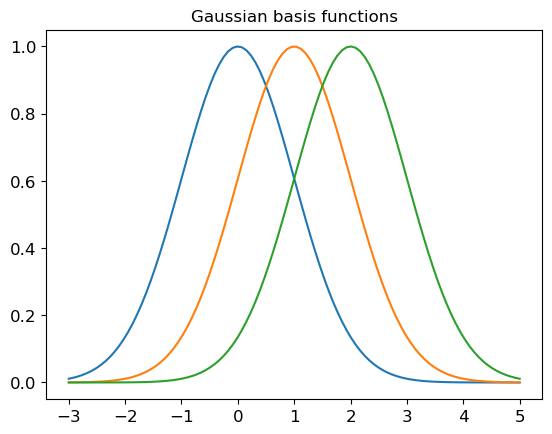

In [7]:
# Test implementation of Gaussian basis functions, see slides for corret output
basis_functions = [Gaussian(mu, 1) for mu in [0, 1, 2]]

for basis in basis_functions:
    plt.plot(np.linspace(-3, 5, 100), basis(np.linspace(-3, 5, 100)))
plt.title("Gaussian basis functions")
plt.show()

<details>
<summary> Hint: </summary>
Use `np.linspace(start, stop, num_points)` for the means
</details>

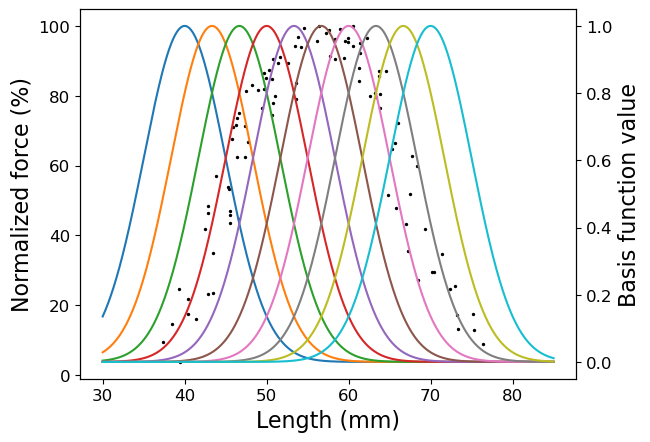

In [37]:
# TODO: Select appropriate means and standard deviations for the basis functions for this data
# Make a list of 10 `Gaussian` objects
mus = np.linspace(40, 70, 10)
sigmas = np.repeat(5, 10)
basis_functions = [Gaussian(mu, sigma) for mu, sigma in zip(mus, sigmas)]
#####

xs_plot = np.linspace(30, 85, 1000)

# Plot basis functions against data to ensure width and locations are reasonable
# The height will not match, but the weights of the regression model will take care of that 
plt.scatter(x_train, y_train, s=2, c="k")
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.twinx()
for basis in basis_functions:
    plt.plot(xs_plot, basis(xs_plot))
plt.ylabel("Basis function value")
plt.show()

In [38]:
# Create a function that evaluates the basis functions on an input vector
def eval_basis_functions(x, basis_functions):
    """
    :param x: array of input values, size (n,)
    :param basis_functions: list of length k of basis function objects whose call method evaluates them

    :return: array of values of basis functions evaluated at points in x, shape (n, k)
    """
    # TODO: Complete the implementation of this function
    return np.array([
        basis(x) for basis in basis_functions
    ]).T
    #####

<details>
<summary> Hint: </summary>
scikit-learn documentation: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">Ridge</a>

</details>

In [39]:
eval_basis_functions(x_train, basis_functions).shape

(100, 10)

In [44]:
# TODO: Instantiate a ridge regression model
model = Ridge(alpha=0.1)
#####

# TODO: Fit the model on the features produced by evaluating basis functions
model.fit(eval_basis_functions(x_train, basis_functions), y_train)
#####
model.coef_

array([-11.38463222,   2.77961397,  24.37684917,  25.73798649,
        14.36812616,  19.67845095,  32.92432845,  25.48836853,
         7.47336093,  -1.51920745])

<details>
<summary> Hint: </summary>
What is the loss function for linear regression? Check the imports at the top for which function to use.
</details>

In [45]:
# TODO: Compute the error on the test and train sets
train_error = mean_squared_error(
    model.predict(eval_basis_functions(x_train, basis_functions)),
    y_train
)

test_error = mean_squared_error(
    model.predict(eval_basis_functions(x_test, basis_functions)),
    y_test
)
#####

print(f"Train error: {train_error:>7.2f}")
print(f" Test error: {test_error:>7.2f}")

Train error:   62.87
 Test error:  133.40


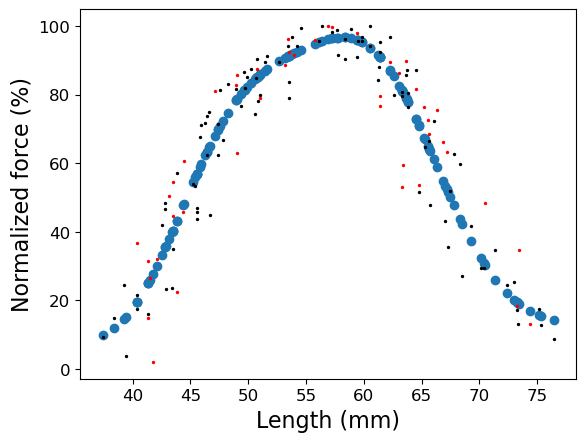

In [47]:
# Plot the predictions of the model on the input of `xs_plot`
plt.scatter(
    data["length"],
    model.predict(eval_basis_functions(data["length"], basis_functions)),
)
#####
plt.scatter(x_test, y_test, c="r", s=2)
plt.scatter(x_train, y_train, c="k", s=2)
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.show()

**Question**: Why should we not apply this regression model to a muscle length of 80 mm?

We would not be able to generalize this pattern to this muscle length. A we don't have prior knowledge of how a long muscle acts. We might hypothesis it exerts a low normalized force percent but this mayb not be the case. This might not be possible and there may be a data issue in a population. 

Respective to this model we can't do this becuase we have not trained our kernel basis functions on this space therefore the prediction would approach zero and we would have no way of approximating this information. Kernels can help us fill in an approximation of a grid within a given subset region, but not extrapolate informatino outside this region as it is not modelling this curve.

# Section 2: What is the effect of the number of basis functions?

TODO:
- Create a set of means and standard deviations for N Gaussian basis functions, where N = [1, 3, 5, 7, 10, 30]
- Train a model for each set of basis functions and collect the train/test errors
- Examine the plot of the train/test errors against number of basis functions

In [65]:
num_bases = [1, 3, 5, 7, 10, 30]

# List of arrays of means, each array should be the length of the number of bases
basis_means = [
    np.linspace(40, 70, n) for n in num_bases
]
# One sigma for each set of basis functions
basis_sigmas = [
    np.repeat(5, n) for n in num_bases
]
#####
all_basis_functions = [[Gaussian(mu, sigma) for mu in means] for means, sigma in zip(basis_means, basis_sigmas)]
for b in all_basis_functions:
    print(b)

TypeError: unsupported format string passed to numpy.ndarray.__format__

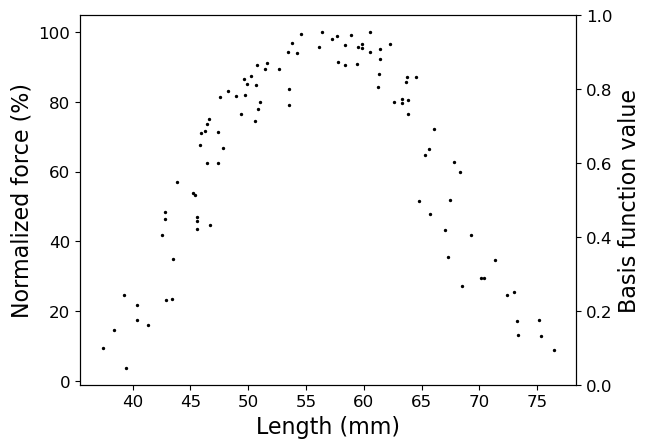

In [58]:
# Plotting code copied for testing out numbers
means = []
sigma = None
basis_functions = []

xs_plot = np.linspace(30, 85, 1000)

plt.scatter(x_train, y_train, s=2, c="k")
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.twinx()
for basis in basis_functions:
    plt.plot(xs_plot, basis(xs_plot))
plt.ylabel("Basis function value")
plt.show()

In [64]:
# Train the models
test_errors = []
train_errors = []

for basis_functions in all_basis_functions:
    # TODO: Train a model with this set of basis functions, append train/test errors to lists above
    model = Ridge(alpha=0.1)
    model.fit(eval_basis_functions(x_train, basis_functions), y_train)
    
    train_errors.append(
        mean_squared_error(
            model.predict(
                eval_basis_functions(x_train, basis_functions)
            ), 
            y_train
        )
    )

    test_errors.append(
        mean_squared_error(
            model.predict(
                eval_basis_functions(x_test, basis_functions)
            ), 
            y_test
        )
    )
    ##### 

ValueError: operands could not be broadcast together with shapes (100,) (3,) 

In [ ]:
# Plot results
plt.plot(num_bases, train_errors, "bo-", label="Train error")
plt.plot(num_bases, test_errors, "ro-", label="Test error")
plt.ylabel("MSE")
plt.xlabel("Number of basis functions")
plt.grid()
plt.legend()
plt.show()

**Question**: What is the optimal number of basis functions? In which number of basis functions is the model overfitting? For which number of basis functions is the model overfitting?

**Question**: Plot `xs_plot` and the model output for the best number of basis functions and the one with 20 basis functions. What do you observe about the plots of the model that overfits?

In [ ]:
# TODO: Plot the curve over `xs_plot` for the best model here
best_num_basis_functions = None
#####

plt.scatter(x_test, y_test, c="r", s=2)
plt.scatter(x_train, y_train, c="k", s=2)
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.title("{best_num_basis_functions} basis functions")
plt.show()

In [ ]:
# TODO: Plot the curve over `xs_plot` for the 20 basis function model here
#####

plt.plot(xs_plot, model.predict(eval_basis_functions(xs_plot, basis_functions)))
plt.scatter(x_test, y_test, c="r", s=2)
plt.scatter(x_train, y_train, c="k", s=2)
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.title("20 basis functions")
plt.show()

# Section 3: ReLU Basis Functions
TODO:
- Complete the ReLU basis function class
- Train a model with 5 basis functions
- Make the same plot of errors against number of basis functions


A shifted ReLU has the following formula:

$$y = \text{ReLU}(x, c) = \begin{cases}
    0 & \text{if} \ x < c, \\
    x - c & \text{if} \ x >= c
\end{cases}
$$

In [ ]:
class Relu:
    def __init__(self, centre):
        """
        Class to represent a shifted linear rectfied unit (ReLU)

        :param centre: Centre of the rectifier
        """
        self.centre = centre

    def __call__(self, x):
        """
        :param x: array of input values for the kernel function
        :return: values of the kernel function evaluated at x
        """
        # TODO: Fill in the equation for ReLU
        y = None
        #####
        return y
    
    def __repr__(self):
        return f"Relu(centre={self.centre:.2f})"

In [ ]:
# Test your implementation and compare to the slides
basis_functions = [Relu(c) for c in [0, 1, 2]]

for basis in basis_functions:
    plt.plot(np.linspace(-3, 5, 100), basis(np.linspace(-3, 5, 100)))
plt.title("ReLU basis functions")
plt.show()

In [ ]:
# TODO: Select appropriate centres for the ReLU basis functions for this dataset
# Use 5 basis functions
basis_functions = []
#####

xs_plot = np.linspace(30, 80, 1000)

plt.scatter(x_train, y_train, s=2, c="k")
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)") 
plt.twinx()
for basis in basis_functions:
    plt.plot(xs_plot, basis(xs_plot))
plt.ylabel("Basis function value")
plt.show()

In [ ]:
# TODO: Train a model and report the train/test error.

train_error = None

test_error = None
#####
print(f"Train error: {train_error:>7.2f}")
print(f" Test error: {test_error:>7.2f}")

In [ ]:
# TODO: Plot the model against the dataset using `xs_plot`

#####
plt.scatter(x_train, y_train, c="k", s=2)
plt.scatter(x_test, y_test, c="r", s=2)
plt.show()
plt.xlabel("Length (mm)")
plt.ylabel("Normalized force (%)")
plt.show()

**Question**: Explain why a linear combination of shifted ReLU features is able to replicate this peaked shape.

In [ ]:
num_bases = np.arange(3, 30, 1)

test_errors = []
train_errors = []

# TODO: Train several models with between 3 and 30 basis functions
for n in num_bases:
    basis_functions = []

    train_errors.append(None)

    test_errors.append(None)
#####

In [ ]:
# Plot errors against number of basis functions
plt.plot(num_bases, train_errors, "bo-", label="Train error")
plt.plot(num_bases, test_errors, "ro-", label="Test error")
plt.ylabel("MSE")
plt.xlabel("Number of basis functions")
plt.grid()
plt.legend()
plt.title("ReLU Basis Functions")
plt.show()

**Question**: Which number of ReLU basis functions would you choose and why?

**Question**: What is one drawback of applying this approach of parameterized basis functions to arbitrary problems?